SNDR before calibration: 18.98 dB
SNDR after calibration: 16.41 dB


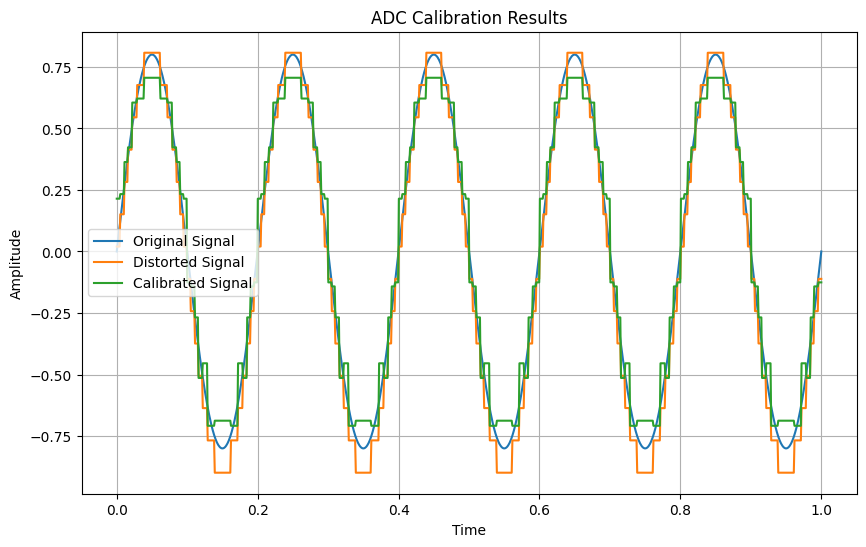

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Simulate ADC with distortions
def simulate_adc(input_signal, bits=4, gain_error=0.05, offset=0.02, skew_factor=0.01):
    # Ideal quantization
    levels = 2**bits
    max_val = 1.0
    step = 2 * max_val / levels
    quantized = np.floor((input_signal + max_val) / step) * step - max_val

    # Add static distortions
    distorted = quantized * (1 + gain_error) + offset

    # Add dynamic distortion (sampling skew simulation)
    time = np.linspace(0, 1, len(input_signal))
    skew = skew_factor * np.sin(2 * np.pi * time)  # Dynamic skew
    distorted += skew * np.gradient(input_signal)  # Signal-dependent skew

    return np.clip(distorted, -max_val, max_val)

# Bit-wise encoding of ADC output
def bit_wise_encode(signal, bits=4):
    levels = 2**bits
    max_val = 1.0
    step = 2 * max_val / levels
    indices = np.floor((signal + max_val) / step).astype(int)
    indices = np.clip(indices, 0, levels - 1)
    binary = np.zeros((len(signal), bits))
    for i in range(len(signal)):
        binary[i] = [int(b) for b in bin(indices[i])[2:].zfill(bits)]
    return binary

# Neural Network Model for Calibration
class ADCCalibrator(nn.Module):
    def __init__(self, input_size, hidden_size=8):
        super(ADCCalibrator, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.output = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        return self.output(x)

# Calculate SNDR
def calculate_sndr(signal, reference):
    signal_power = np.mean(signal**2)
    noise_distortion = signal - reference
    noise_power = np.mean(noise_distortion**2)
    sndr = 10 * np.log10(signal_power / noise_power)
    return sndr

# Main simulation
np.random.seed(42)
torch.manual_seed(42)

# Generate input signal (sine wave)
t = np.linspace(0, 1, 1000)
input_signal = 0.8 * np.sin(2 * np.pi * 5 * t)

# Simulate ADC with distortions
bits = 4
distorted_signal = simulate_adc(input_signal, bits=bits)

# Bit-wise encode the distorted signal
encoded_signal = bit_wise_encode(distorted_signal, bits=bits)

# Prepare data for neural network
X = torch.tensor(encoded_signal, dtype=torch.float32)
y = torch.tensor(input_signal, dtype=torch.float32).view(-1, 1)

# Initialize and train the neural network
model = ADCCalibrator(input_size=bits)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

# Training loop
epochs = 500
for epoch in range(epochs):
    optimizer.zero_grad()
    output = model(X)
    loss = criterion(output, y)
    loss.backward()
    optimizer.step()

# Get calibrated output
model.eval()
with torch.no_grad():
    calibrated_signal = model(X).numpy().flatten()

# Calculate SNDR before and after calibration
sndr_before = calculate_sndr(distorted_signal, input_signal)
sndr_after = calculate_sndr(calibrated_signal, input_signal)

# Print results
print(f"SNDR before calibration: {sndr_before:.2f} dB")
print(f"SNDR after calibration: {sndr_after:.2f} dB")

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(t, input_signal, label="Original Signal")
plt.plot(t, distorted_signal, label="Distorted Signal")
plt.plot(t, calibrated_signal, label="Calibrated Signal")
plt.title("ADC Calibration Results")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.savefig("adc_calibration_results.png")

Epoch 0, Loss: 0.312126
Epoch 100, Loss: 0.040781
Epoch 200, Loss: 0.001619
Epoch 300, Loss: 0.001170
Epoch 400, Loss: 0.001095
Epoch 500, Loss: 0.001078
Epoch 600, Loss: 0.001070
Epoch 700, Loss: 0.001066
Epoch 800, Loss: 0.001065
Epoch 900, Loss: 0.001064

SNDR before calibration: 24.16 dB
SNDR after calibration: 24.39 dB
SNDR improvement: 0.23 dB


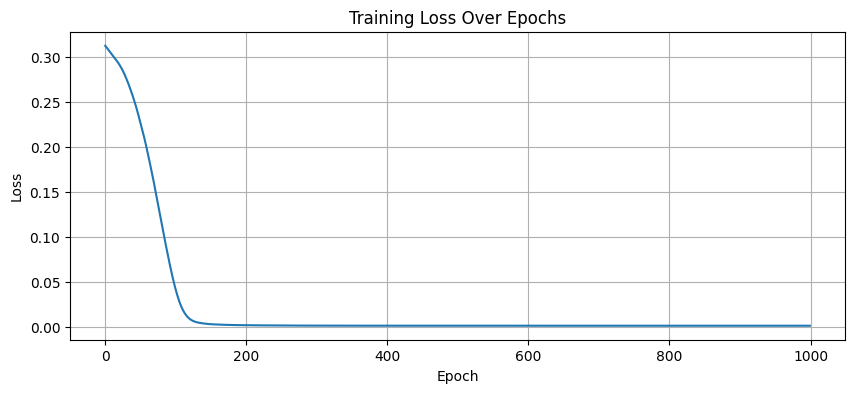

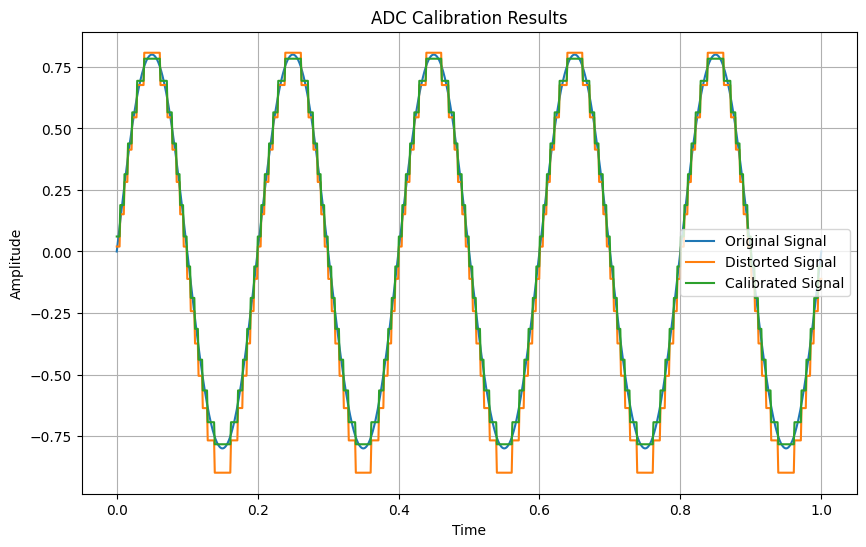

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Simulate ADC with distortions
def simulate_adc(input_signal, bits=4, gain_error=0.05, offset=0.02, skew_factor=0.01):
    levels = 2**bits
    max_val = 1.0
    step = 2 * max_val / levels
    quantized = np.floor((input_signal + max_val) / step) * step - max_val

    # Add static distortions
    distorted = quantized * (1 + gain_error) + offset

    # Add dynamic distortion (sampling skew simulation)
    time = np.linspace(0, 1, len(input_signal))
    skew = skew_factor * np.sin(2 * np.pi * time)
    distorted += skew * np.gradient(input_signal)

    return np.clip(distorted, -max_val, max_val)

# Bit-wise encoding of ADC output
def bit_wise_encode(signal, bits=4):
    levels = 2**bits
    max_val = 1.0
    step = 2 * max_val / levels
    indices = np.floor((signal + max_val) / step).astype(int)
    indices = np.clip(indices, 0, levels - 1)
    binary = np.zeros((len(signal), bits))
    for i in range(len(signal)):
        binary[i] = [int(b) for b in bin(indices[i])[2:].zfill(bits)]
    return binary

# Neural Network Model for Calibration
class ADCCalibrator(nn.Module):
    def __init__(self, input_size, hidden_size=16):  # Increased hidden size
        super(ADCCalibrator, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.layer3 = nn.Linear(hidden_size, hidden_size)  # Added an extra layer
        self.output = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.relu(self.layer3(x))
        return self.output(x)

# Calculate SNDR with debugging
def calculate_sndr(signal, reference):
    # Ensure signals are aligned and normalized
    signal = np.array(signal)
    reference = np.array(reference)

    # Remove DC offset
    signal = signal - np.mean(signal)
    reference = reference - np.mean(reference)

    # Normalize amplitudes for fair comparison
    signal = signal / np.max(np.abs(signal))
    reference = reference / np.max(np.abs(reference))

    signal_power = np.mean(signal**2)
    noise_distortion = signal - reference
    noise_power = np.mean(noise_distortion**2)

    if noise_power == 0:
        return float('inf')  # Avoid division by zero
    sndr = 10 * np.log10(signal_power / noise_power)
    return sndr

# Main simulation
np.random.seed(42)
torch.manual_seed(42)

# Generate input signal (sine wave)
t = np.linspace(0, 1, 1000)
input_signal = 0.8 * np.sin(2 * np.pi * 5 * t)

# Simulate ADC with distortions
bits = 4
distorted_signal = simulate_adc(input_signal, bits=bits)

# Bit-wise encode the distorted signal
encoded_signal = bit_wise_encode(distorted_signal, bits=bits)

# Prepare data for neural network
X = torch.tensor(encoded_signal, dtype=torch.float32)
y = torch.tensor(input_signal, dtype=torch.float32).view(-1, 1)

# Initialize and train the neural network
model = ADCCalibrator(input_size=bits, hidden_size=16)  # Increased hidden size
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Switched to Adam optimizer
criterion = nn.MSELoss()

# Training loop with loss monitoring
epochs = 1000  # Increased epochs
losses = []
for epoch in range(epochs):
    optimizer.zero_grad()
    output = model(X)
    loss = criterion(output, y)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

# Get calibrated output
model.eval()
with torch.no_grad():
    calibrated_signal = model(X).numpy().flatten()

# Calculate SNDR before and after calibration
sndr_before = calculate_sndr(distorted_signal, input_signal)
sndr_after = calculate_sndr(calibrated_signal, input_signal)

# Print results
print(f"\nSNDR before calibration: {sndr_before:.2f} dB")
print(f"SNDR after calibration: {sndr_after:.2f} dB")
print(f"SNDR improvement: {sndr_after - sndr_before:.2f} dB")

# Plot training loss
plt.figure(figsize=(10, 4))
plt.plot(losses)
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.savefig("training_loss.png")

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(t, input_signal, label="Original Signal")
plt.plot(t, distorted_signal, label="Distorted Signal")
plt.plot(t, calibrated_signal, label="Calibrated Signal")
plt.title("ADC Calibration Results")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.savefig("adc_calibration_results.png")

Epoch 0, Loss: 0.321031
Epoch 100, Loss: 0.001444
Epoch 200, Loss: 0.001070
Epoch 300, Loss: 0.001062
Epoch 400, Loss: 0.001062
Epoch 500, Loss: 0.001062
Epoch 600, Loss: 0.001062
Epoch 700, Loss: 0.001062
Epoch 800, Loss: 0.001062
Epoch 900, Loss: 0.001062
Epoch 1000, Loss: 0.001062
Epoch 1100, Loss: 0.001062
Epoch 1200, Loss: 0.001062
Epoch 1300, Loss: 0.001062
Epoch 1400, Loss: 0.001062
Epoch 1500, Loss: 0.001062
Epoch 1600, Loss: 0.001062
Epoch 1700, Loss: 0.001062
Epoch 1800, Loss: 0.001062
Epoch 1900, Loss: 0.001062

SNDR before calibration: 15.10 dB
SNDR after calibration: 24.78 dB
SNDR improvement: 9.68 dB


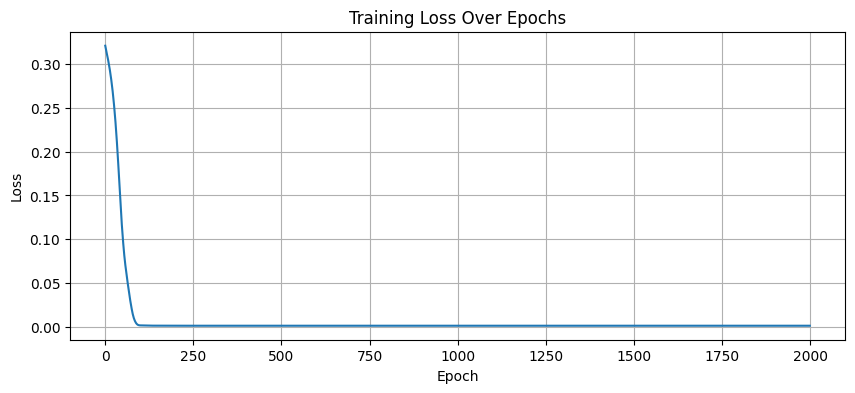

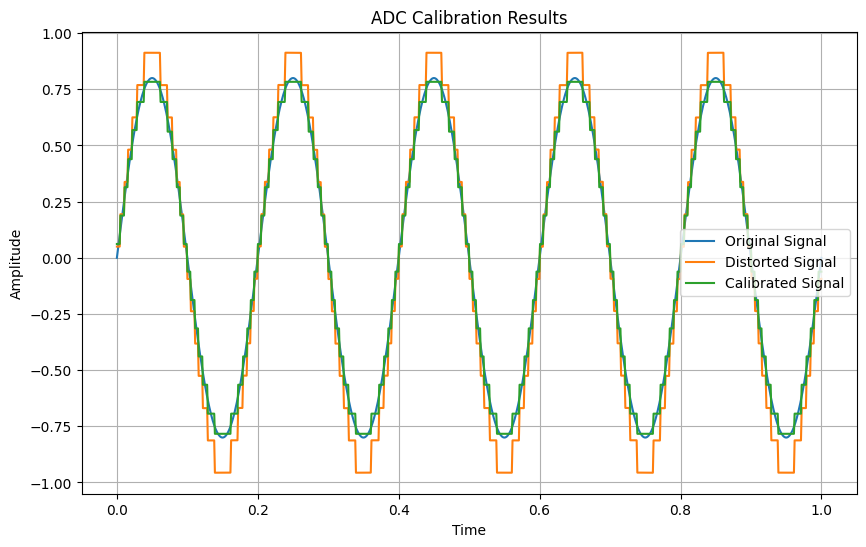

In [ ]:
#working code
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# Simulate ADC with distortions
def simulate_adc(input_signal, bits=4, gain_error=0.15, offset=0.05, skew_factor=0.03):
    levels = 2**bits
    max_val = 1.0
    step = 2 * max_val / levels
    quantized = np.floor((input_signal + max_val) / step) * step - max_val

    # Add static distortions (increased magnitude)
    distorted = quantized * (1 + gain_error) + offset

    # Add dynamic distortion (increased skew)
    time = np.linspace(0, 1, len(input_signal))
    skew = skew_factor * np.sin(2 * np.pi * time)
    distorted += skew * np.gradient(input_signal)

    return np.clip(distorted, -max_val, max_val)

# Bit-wise encoding of ADC output
def bit_wise_encode(signal, bits=4):
    levels = 2**bits
    max_val = 1.0
    step = 2 * max_val / levels
    indices = np.floor((signal + max_val) / step).astype(int)
    indices = np.clip(indices, 0, levels - 1)
    binary = np.zeros((len(signal), bits))
    for i in range(len(signal)):
        binary[i] = [int(b) for b in bin(indices[i])[2:].zfill(bits)]
    return binary

# Neural Network Model for Calibration
class ADCCalibrator(nn.Module):
    def __init__(self, input_size, hidden_size=32):
        super(ADCCalibrator, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.layer3 = nn.Linear(hidden_size, hidden_size)
        self.layer4 = nn.Linear(hidden_size, hidden_size)  # Added another layer
        self.output = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.relu(self.layer3(x))
        x = self.relu(self.layer4(x))
        return self.output(x)

# Calculate SNDR with adjusted normalization
def calculate_sndr(signal, reference):
    signal = np.array(signal)
    reference = np.array(reference)

    # Remove DC offset
    signal = signal - np.mean(signal)
    reference = reference - np.mean(reference)

    # Compute SNDR without over-normalizing amplitudes
    signal_power = np.mean(reference**2)  # Use reference for signal power
    noise_distortion = signal - reference
    noise_power = np.mean(noise_distortion**2)

    if noise_power == 0:
        return float('inf')
    sndr = 10 * np.log10(signal_power / noise_power)
    return sndr

# Main simulation
np.random.seed(42)
torch.manual_seed(42)

# Generate input signal (sine wave)
t = np.linspace(0, 1, 1000)
input_signal = 0.8 * np.sin(2 * np.pi * 5 * t)

# Simulate ADC with increased distortions
bits = 4
distorted_signal = simulate_adc(input_signal, bits=bits, gain_error=0.15, offset=0.05, skew_factor=0.03)

# Bit-wise encode the distorted signal
encoded_signal = bit_wise_encode(distorted_signal, bits=bits)

# Prepare data for neural network
X = torch.tensor(encoded_signal, dtype=torch.float32)
y = torch.tensor(input_signal, dtype=torch.float32).view(-1, 1)

# Initialize and train the neural network
model = ADCCalibrator(input_size=bits, hidden_size=32)  # Increased hidden size
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.5)  # Learning rate scheduler
criterion = nn.MSELoss()

# Training loop with loss monitoring
epochs = 2000  # Increased epochs
losses = []
for epoch in range(epochs):
    optimizer.zero_grad()
    output = model(X)
    loss = criterion(output, y)
    loss.backward()
    optimizer.step()
    scheduler.step()
    losses.append(loss.item())
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

# Get calibrated output
model.eval()
with torch.no_grad():
    calibrated_signal = model(X).numpy().flatten()

# Calculate SNDR before and after calibration
sndr_before = calculate_sndr(distorted_signal, input_signal)
sndr_after = calculate_sndr(calibrated_signal, input_signal)

# Print results
print(f"\nSNDR before calibration: {sndr_before:.2f} dB")
print(f"SNDR after calibration: {sndr_after:.2f} dB")
print(f"SNDR improvement: {sndr_after - sndr_before:.2f} dB")

# Plot training loss
plt.figure(figsize=(10, 4))
plt.plot(losses)
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.savefig("training_loss.png")

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(t, input_signal, label="Original Signal")
plt.plot(t, distorted_signal, label="Distorted Signal")
plt.plot(t, calibrated_signal, label="Calibrated Signal")
plt.title("ADC Calibration Results")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.savefig("adc_calibration_results.png")

In [ ]:
#working code DNL and INL added

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib
matplotlib.use('Agg')  # Use non-interactive backend
import matplotlib.pyplot as plt
import os

# Simulate ADC with distortions
def simulate_adc(input_signal, bits=4, gain_error=0.15, offset=0.05, skew_factor=0.03):
    levels = 2**bits
    max_val = 1.0
    step = 2 * max_val / levels
    quantized = np.floor((input_signal + max_val) / step) * step - max_val
    distorted = quantized * (1 + gain_error) + offset
    time = np.linspace(0, 1, len(input_signal))
    skew = skew_factor * np.sin(2 * np.pi * time)
    distorted += skew * np.gradient(input_signal)
    return np.clip(distorted, -max_val, max_val)

# Bit-wise encoding of ADC output
def bit_wise_encode(signal, bits=4):
    levels = 2**bits
    max_val = 1.0
    step = 2 * max_val / levels
    indices = np.floor((signal + max_val) / step).astype(int)
    indices = np.clip(indices, 0, levels - 1)
    binary = np.zeros((len(signal), bits))
    for i in range(len(signal)):
        binary[i] = [int(b) for b in bin(indices[i])[2:].zfill(bits)]
    return binary

# Neural Network Model for Calibration
class ADCCalibrator(nn.Module):
    def __init__(self, input_size, hidden_size=32):
        super(ADCCalibrator, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.layer3 = nn.Linear(hidden_size, hidden_size)
        self.layer4 = nn.Linear(hidden_size, hidden_size)
        self.output = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.relu(self.layer3(x))
        x = self.relu(self.layer4(x))
        return self.output(x)

# Calculate SNDR
def calculate_sndr(signal, reference):
    signal = np.array(signal)
    reference = np.array(reference)
    signal = signal - np.mean(signal)
    reference = reference - np.mean(reference)
    signal_power = np.mean(reference**2)
    noise_distortion = signal - reference
    noise_power = np.mean(noise_distortion**2)
    if noise_power == 0:
        return float('inf')
    sndr = 10 * np.log10(signal_power / noise_power)
    return sndr

# Calculate DNL and INL
def calculate_dnl_inl(input_signal, output_signal, bits=4):
    levels = 2**bits
    max_val = 1.0
    ideal_step = 2 * max_val / levels
    code_indices = np.floor((output_signal + max_val) / ideal_step).astype(int)
    code_indices = np.clip(code_indices, 0, levels - 1)
    code_outputs = np.zeros(levels)
    code_counts = np.zeros(levels)
    for i, code in enumerate(code_indices):
        code_outputs[code] += output_signal[i]
        code_counts[code] += 1
    code_outputs = np.divide(code_outputs, code_counts, where=code_counts != 0)
    code_outputs[code_counts == 0] = np.nan
    ideal_outputs = np.linspace(-max_val, max_val - ideal_step, levels)
    actual_steps = np.diff(code_outputs)
    dnl = (actual_steps - ideal_step) / ideal_step
    dnl = np.nan_to_num(dnl, nan=0)
    inl = np.zeros(levels)
    valid_codes = ~np.isnan(code_outputs)
    inl[valid_codes] = (code_outputs[valid_codes] - ideal_outputs[valid_codes]) / ideal_step
    inl = np.nan_to_num(inl, nan=0)
    return dnl, inl

# Main simulation
np.random.seed(42)
torch.manual_seed(42)

# Generate input signal (sine wave)
t = np.linspace(0, 1, 1000)
input_signal = 0.8 * np.sin(2 * np.pi * 5 * t)

# Simulate ADC with distortions
bits = 4
distorted_signal = simulate_adc(input_signal, bits=bits, gain_error=0.15, offset=0.05, skew_factor=0.03)

# Bit-wise encode the distorted signal
encoded_signal = bit_wise_encode(distorted_signal, bits=bits)

# Prepare data for neural network
X = torch.tensor(encoded_signal, dtype=torch.float32)
y = torch.tensor(input_signal, dtype=torch.float32).view(-1, 1)

# Initialize and train the neural network
model = ADCCalibrator(input_size=bits, hidden_size=32)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.5)
criterion = nn.MSELoss()

# Training loop
epochs = 2000
losses = []
for epoch in range(epochs):
    optimizer.zero_grad()
    output = model(X)
    loss = criterion(output, y)
    loss.backward()
    optimizer.step()
    scheduler.step()
    losses.append(loss.item())
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

# Get calibrated output
model.eval()
with torch.no_grad():
    calibrated_signal = model(X).numpy().flatten()

# Calculate SNDR
sndr_before = calculate_sndr(distorted_signal, input_signal)
sndr_after = calculate_sndr(calibrated_signal, input_signal)

# Calculate DNL and INL
dnl_distorted, inl_distorted = calculate_dnl_inl(input_signal, distorted_signal, bits=bits)
dnl_calibrated, inl_calibrated = calculate_dnl_inl(input_signal, calibrated_signal, bits=bits)

# Print results
print(f"\nSNDR before calibration: {sndr_before:.2f} dB")
print(f"SNDR after calibration: {sndr_after:.2f} dB")
print(f"SNDR improvement: {sndr_after - sndr_before:.2f} dB")
print(f"\nMax DNL before calibration: {np.max(np.abs(dnl_distorted)):.3f} LSB")
print(f"Max DNL after calibration: {np.max(np.abs(dnl_calibrated)):.3f} LSB")
print(f"Max INL before calibration: {np.max(np.abs(inl_distorted)):.3f} LSB")
print(f"Max INL after calibration: {np.max(np.abs(inl_calibrated)):.3f} LSB")

# Plotting with error handling
output_dir = "plots"
os.makedirs(output_dir, exist_ok=True)  # Create output directory if it doesn't exist

try:
    # Plot training loss
    plt.figure(figsize=(10, 4))
    plt.plot(losses)
    plt.title("Training Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.savefig(os.path.join(output_dir, "training_loss.png"))
    plt.close()
    print(f"Saved training_loss.png to {output_dir}")

    # Plot ADC signals
    plt.figure(figsize=(10, 6))
    plt.plot(t, input_signal, label="Original Signal")
    plt.plot(t, distorted_signal, label="Distorted Signal")
    plt.plot(t, calibrated_signal, label="Calibrated Signal")
    plt.title("ADC Calibration Results")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(output_dir, "adc_calibration_results.png"))
    plt.close()
    print(f"Saved adc_calibration_results.png to {output_dir}")

    # Plot DNL
    plt.figure(figsize=(10, 4))
    plt.plot(range(len(dnl_distorted)), dnl_distorted, label="DNL (Distorted)")
    plt.plot(range(len(dnl_calibrated)), dnl_calibrated, label="DNL (Calibrated)")
    plt.title("Differential Non-Linearity (DNL)")
    plt.xlabel("Code Transition")
    plt.ylabel("DNL (LSB)")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(output_dir, "dnl_comparison.png"))
    plt.close()
    print(f"Saved dnl_comparison.png to {output_dir}")

    # Plot INL
    plt.figure(figsize=(10, 4))
    plt.plot(range(len(inl_distorted)), inl_distorted, label="INL (Distorted)")
    plt.plot(range(len(inl_calibrated)), inl_calibrated, label="INL (Calibrated)")
    plt.title("Integral Non-Linearity (INL)")
    plt.xlabel("Code")
    plt.ylabel("INL (LSB)")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(output_dir, "inl_comparison.png"))
    plt.close()
    print(f"Saved inl_comparison.png to {output_dir}")

except Exception as e:
    print(f"Error during plotting: {e}")


Epoch 0, Loss: 0.321031
Epoch 100, Loss: 0.001444
Epoch 200, Loss: 0.001070
Epoch 300, Loss: 0.001062
Epoch 400, Loss: 0.001062
Epoch 500, Loss: 0.001062
Epoch 600, Loss: 0.001062
Epoch 700, Loss: 0.001062
Epoch 800, Loss: 0.001062
Epoch 900, Loss: 0.001062
Epoch 1000, Loss: 0.001062
Epoch 1100, Loss: 0.001062
Epoch 1200, Loss: 0.001062
Epoch 1300, Loss: 0.001062
Epoch 1400, Loss: 0.001062
Epoch 1500, Loss: 0.001062
Epoch 1600, Loss: 0.001062
Epoch 1700, Loss: 0.001062
Epoch 1800, Loss: 0.001062
Epoch 1900, Loss: 0.001062

SNDR before calibration: 15.10 dB
SNDR after calibration: 24.78 dB
SNDR improvement: 9.68 dB

Max DNL before calibration: 0.995 LSB
Max DNL after calibration: 0.283 LSB
Max INL before calibration: 0.997 LSB
Max INL after calibration: 0.734 LSB
Saved training_loss.png to plots
Saved adc_calibration_results.png to plots
Saved dnl_comparison.png to plots
Saved inl_comparison.png to plots


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib
matplotlib.use('Agg')  # Non-interactive backend
import matplotlib.pyplot as plt
import os

# Simulate ADC with distortions
def simulate_adc(input_signal, bits=4, gain_error=0.15, offset=0.05, skew_factor=0.03):
    levels = 2**bits
    max_val = 1.0
    step = 2 * max_val / levels
    quantized = np.floor((input_signal + max_val) / step) * step - max_val
    distorted = quantized * (1 + gain_error) + offset
    time = np.linspace(0, 1, len(input_signal))
    skew = skew_factor * np.sin(2 * np.pi * time)
    distorted += skew * np.gradient(input_signal)
    return np.clip(distorted, -max_val, max_val)

# Bit-wise encoding of ADC output
def bit_wise_encode(signal, bits=4):
    levels = 2**bits
    max_val = 1.0
    step = 2 * max_val / levels
    indices = np.floor((signal + max_val) / step).astype(int)
    indices = np.clip(indices, 0, levels - 1)
    binary = np.zeros((len(signal), bits))
    for i in range(len(signal)):
        binary[i] = [int(b) for b in bin(indices[i])[2:].zfill(bits)]
    return binary

# Neural Network Model for Calibration (with increased capacity)
class ADCCalibrator(nn.Module):
    def __init__(self, input_size, hidden_size=64):  # Increased hidden size
        super(ADCCalibrator, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.layer3 = nn.Linear(hidden_size, hidden_size)
        self.layer4 = nn.Linear(hidden_size, hidden_size)
        self.layer5 = nn.Linear(hidden_size, hidden_size)  # Added fifth layer
        self.output = nn.Linear(hidden_size, 1)

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.relu(self.layer3(x))
        x = self.relu(self.layer4(x))
        x = self.relu(self.layer5(x))
        return self.output(x)

# Calculate SNDR
def calculate_sndr(signal, reference):
    signal = np.array(signal)
    reference = np.array(reference)
    signal = signal - np.mean(signal)
    reference = reference - np.mean(reference)
    signal_power = np.mean(reference**2)
    noise_distortion = signal - reference
    noise_power = np.mean(noise_distortion**2)
    if noise_power == 0:
        return float('inf')
    sndr = 10 * np.log10(signal_power / noise_power)
    return sndr

# Calculate DNL and INL
def calculate_dnl_inl(input_signal, output_signal, bits=4):
    levels = 2**bits
    max_val = 1.0
    ideal_step = 2 * max_val / levels
    code_indices = np.floor((output_signal + max_val) / ideal_step).astype(int)
    code_indices = np.clip(code_indices, 0, levels - 1)
    code_outputs = np.zeros(levels)
    code_counts = np.zeros(levels)
    for i, code in enumerate(code_indices):
        code_outputs[code] += output_signal[i]
        code_counts[code] += 1
    code_outputs = np.divide(code_outputs, code_counts, where=code_counts != 0)
    code_outputs[code_counts == 0] = np.nan
    ideal_outputs = np.linspace(-max_val, max_val - ideal_step, levels)
    actual_steps = np.diff(code_outputs)
    dnl = (actual_steps - ideal_step) / ideal_step
    dnl = np.nan_to_num(dnl, nan=0)
    inl = np.zeros(levels)
    valid_codes = ~np.isnan(code_outputs)
    inl[valid_codes] = (code_outputs[valid_codes] - ideal_outputs[valid_codes]) / ideal_step
    inl = np.nan_to_num(inl, nan=0)
    return dnl, inl

# Main simulation
np.random.seed(42)
torch.manual_seed(42)

# Generate input signal (ramp instead of sine wave)
t = np.linspace(0, 1, 1000)
input_signal = np.linspace(-0.95, 0.95, 1000)  # Ramp input to cover full range

# Simulate ADC with distortions
bits = 4
distorted_signal = simulate_adc(input_signal, bits=bits, gain_error=0.15, offset=0.05, skew_factor=0.03)

# Bit-wise encode the distorted signal
encoded_signal = bit_wise_encode(distorted_signal, bits=bits)

# Prepare data for neural network
X = torch.tensor(encoded_signal, dtype=torch.float32)
y = torch.tensor(input_signal, dtype=torch.float32).view(-1, 1)

# Initialize and train the neural network
model = ADCCalibrator(input_size=bits, hidden_size=64)  # Increased hidden size
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.1)  # Adjusted scheduler
criterion = nn.MSELoss()

# Training loop (increased epochs)
epochs = 3000
losses = []
for epoch in range(epochs):
    optimizer.zero_grad()
    output = model(X)
    loss = criterion(output, y)
    loss.backward()
    optimizer.step()
    scheduler.step()
    losses.append(loss.item())
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

# Get calibrated output
model.eval()
with torch.no_grad():
    calibrated_signal = model(X).numpy().flatten()

# Calculate SNDR
sndr_before = calculate_sndr(distorted_signal, input_signal)
sndr_after = calculate_sndr(calibrated_signal, input_signal)

# Calculate DNL and INL
dnl_distorted, inl_distorted = calculate_dnl_inl(input_signal, distorted_signal, bits=bits)
dnl_calibrated, inl_calibrated = calculate_dnl_inl(input_signal, calibrated_signal, bits=bits)

# Print results
print(f"\nSNDR before calibration: {sndr_before:.2f} dB")
print(f"SNDR after calibration: {sndr_after:.2f} dB")
print(f"SNDR improvement: {sndr_after - sndr_before:.2f} dB")
print(f"\nMax DNL before calibration: {np.max(np.abs(dnl_distorted)):.3f} LSB")
print(f"Max DNL after calibration: {np.max(np.abs(dnl_calibrated)):.3f} LSB")
print(f"Max INL before calibration: {np.max(np.abs(inl_distorted)):.3f} LSB")
print(f"Max INL after calibration: {np.max(np.abs(inl_calibrated)):.3f} LSB")

# Plotting with error handling
output_dir = "plots"
os.makedirs(output_dir, exist_ok=True)

try:
    # Plot training loss
    plt.figure(figsize=(10, 4))
    plt.plot(losses)
    plt.title("Training Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.savefig(os.path.join(output_dir, "training_loss.png"))
    plt.close()
    print(f"Saved training_loss.png to {output_dir}")

    # Plot ADC signals
    plt.figure(figsize=(10, 6))
    plt.plot(t, input_signal, label="Original Signal")
    plt.plot(t, distorted_signal, label="Distorted Signal")
    plt.plot(t, calibrated_signal, label="Calibrated Signal")
    plt.title("ADC Calibration Results")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(output_dir, "adc_calibration_results.png"))
    plt.close()
    print(f"Saved adc_calibration_results.png to {output_dir}")

    # Plot DNL
    plt.figure(figsize=(10, 4))
    plt.plot(range(len(dnl_distorted)), dnl_distorted, label="DNL (Distorted)")
    plt.plot(range(len(dnl_calibrated)), dnl_calibrated, label="DNL (Calibrated)")
    plt.title("Differential Non-Linearity (DNL)")
    plt.xlabel("Code Transition")
    plt.ylabel("DNL (LSB)")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(output_dir, "dnl_comparison.png"))
    plt.close()
    print(f"Saved dnl_comparison.png to {output_dir}")

    # Plot INL
    plt.figure(figsize=(10, 4))
    plt.plot(range(len(inl_distorted)), inl_distorted, label="INL (Distorted)")
    plt.plot(range(len(inl_calibrated)), inl_calibrated, label="INL (Calibrated)")
    plt.title("Integral Non-Linearity (INL)")
    plt.xlabel("Code")
    plt.ylabel("INL (LSB)")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(output_dir, "inl_comparison.png"))
    plt.close()
    print(f"Saved inl_comparison.png to {output_dir}")

except Exception as e:
    print(f"Error during plotting: {e}")

Epoch 0, Loss: 0.303352
Epoch 100, Loss: 0.001764
Epoch 200, Loss: 0.001742
Epoch 300, Loss: 0.001742
Epoch 400, Loss: 0.001742
Epoch 500, Loss: 0.001742
Epoch 600, Loss: 0.001742
Epoch 700, Loss: 0.001742
Epoch 800, Loss: 0.001742
Epoch 900, Loss: 0.001742
Epoch 1000, Loss: 0.001742
Epoch 1100, Loss: 0.001742
Epoch 1200, Loss: 0.001742
Epoch 1300, Loss: 0.001742
Epoch 1400, Loss: 0.001742
Epoch 1500, Loss: 0.001742
Epoch 1600, Loss: 0.001742
Epoch 1700, Loss: 0.001742
Epoch 1800, Loss: 0.001742
Epoch 1900, Loss: 0.001742
Epoch 2000, Loss: 0.001742
Epoch 2100, Loss: 0.001742
Epoch 2200, Loss: 0.001742
Epoch 2300, Loss: 0.001742
Epoch 2400, Loss: 0.001742
Epoch 2500, Loss: 0.001742
Epoch 2600, Loss: 0.001742
Epoch 2700, Loss: 0.001742
Epoch 2800, Loss: 0.001742
Epoch 2900, Loss: 0.001742

SNDR before calibration: 16.26 dB
SNDR after calibration: 22.38 dB
SNDR improvement: 6.13 dB

Max DNL before calibration: 0.414 LSB
Max DNL after calibration: 0.301 LSB
Max INL before calibration: 1.00

In [11]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib
matplotlib.use('Agg')  # Use non-interactive backend
import matplotlib.pyplot as plt
import os

# Simulate ADC with dynamic distortions only
def simulate_adc(input_signal, bits=4, skew_factor=0.03, gain_mod_factor=0.05, gain_mod_freq=10):
    levels = 2**bits
    max_val = 1.0
    step = 2 * max_val / levels
    quantized = np.floor((input_signal + max_val) / step) * step - max_val
    distorted = quantized  # No static distortions

    # Dynamic distortion 1: Skew
    time = np.linspace(0, 1, len(input_signal))
    skew = skew_factor * np.sin(2 * np.pi * time)
    distorted += skew * np.gradient(input_signal)

    # Dynamic distortion 2: Time-varying gain modulation
    gain_mod = 1 + gain_mod_factor * np.sin(2 * np.pi * gain_mod_freq * time)
    distorted *= gain_mod

    return np.clip(distorted, -max_val, max_val)

# Neural Network Model with Enhanced 1D CNN and Residual Connection
class ADCCalibrator(nn.Module):
    def __init__(self, input_size=1, hidden_size=128):
        super(ADCCalibrator, self).__init__()
        self.conv1 = nn.Conv1d(input_size, hidden_size, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(hidden_size, hidden_size, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(hidden_size, hidden_size, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(hidden_size, hidden_size, kernel_size=3, padding=1)
        self.conv5 = nn.Conv1d(hidden_size, 1, kernel_size=3, padding=1)
        self.tanh = nn.Tanh()  # To constrain output to [-1, 1]

    def forward(self, x):
        # Input x: (batch, seq_len, input_size) -> Transpose to (batch, input_size, seq_len) for Conv1d
        x = x.transpose(1, 2)  # (batch, input_size, seq_len)
        residual = x  # Save for residual connection
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.conv5(x)  # (batch, 1, seq_len)
        x = self.tanh(x)  # Constrain to [-1, 1]
        x = x.transpose(1, 2)  # Back to (batch, seq_len, 1)
        # Add residual (distorted signal) to the output
        x = x + residual.transpose(1, 2)  # Ensure residual matches dimensions
        # Scale output to [-0.95, 0.95]
        x = x * 0.95
        return x

# Calculate SNDR
def calculate_sndr(signal, reference):
    signal = np.array(signal)
    reference = np.array(reference)
    signal = signal - np.mean(signal)
    reference = reference - np.mean(reference)
    signal_power = np.mean(reference**2)
    noise_distortion = signal - reference
    noise_power = np.mean(noise_distortion**2)
    if noise_power == 0:
        return float('inf')
    sndr = 10 * np.log10(signal_power / noise_power)
    return sndr

# Calculate DNL and INL
def calculate_dnl_inl(input_signal, output_signal, bits=4):
    levels = 2**bits
    max_val = 1.0
    step = 2 * max_val / levels
    code_indices = np.floor((output_signal + max_val) / step).astype(int)
    code_indices = np.clip(code_indices, 0, levels - 1)
    code_outputs = np.zeros(levels)
    code_counts = np.zeros(levels)
    for i, code in enumerate(code_indices):
        code_outputs[code] += output_signal[i]
        code_counts[code] += 1
    code_outputs = np.divide(code_outputs, code_counts, where=code_counts != 0)
    code_outputs[code_counts == 0] = np.nan
    ideal_outputs = np.linspace(-max_val, max_val - step, levels)
    actual_steps = np.diff(code_outputs)
    dnl = (actual_steps - step) / step
    dnl = np.nan_to_num(dnl, nan=0)
    inl = np.zeros(levels)
    valid_codes = ~np.isnan(code_outputs)
    inl[valid_codes] = (code_outputs[valid_codes] - ideal_outputs[valid_codes]) / step
    inl = np.nan_to_num(inl, nan=0)
    return dnl, inl

# Main simulation
np.random.seed(42)
torch.manual_seed(42)

# Generate input signal (ramp)
t = np.linspace(0, 1, 1000)
input_signal = np.linspace(-0.95, 0.95, 1000)  # Ramp input to cover full range

# Simulate ADC with dynamic distortions
bits = 4
distorted_signal = simulate_adc(input_signal, bits=bits, skew_factor=0.03, gain_mod_factor=0.05, gain_mod_freq=10)

# Normalize the distorted signal to [-1, 1] for input
distorted_normalized = distorted_signal / 1.0  # Already in [-1, 1], but ensures consistency

# Prepare data for neural network
X = torch.tensor(distorted_normalized, dtype=torch.float32).view(1, -1, 1)  # Shape: (1, seq_len, 1)
y = torch.tensor(input_signal, dtype=torch.float32).view(1, -1, 1)  # Shape: (1, seq_len, 1)

# Initialize and train the neural network
model = ADCCalibrator(input_size=1, hidden_size=128)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.1)  # Adjusted scheduler
criterion = nn.MSELoss()

# Training loop
epochs = 5000
losses = []
for epoch in range(epochs):
    optimizer.zero_grad()
    output = model(X)  # Shape: (1, seq_len, 1)
    loss = criterion(output, y)
    loss.backward()
    optimizer.step()
    scheduler.step()
    losses.append(loss.item())
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

# Get calibrated output
model.eval()
with torch.no_grad():
    calibrated_signal = model(X).squeeze(0).numpy().flatten()  # Remove batch dimension and flatten

# Calculate SNDR
sndr_before = calculate_sndr(distorted_signal, input_signal)
sndr_after = calculate_sndr(calibrated_signal, input_signal)

# Calculate DNL and INL
dnl_distorted, inl_distorted = calculate_dnl_inl(input_signal, distorted_signal, bits=bits)
dnl_calibrated, inl_calibrated = calculate_dnl_inl(input_signal, calibrated_signal, bits=bits)

# Print results
print(f"\nSNDR before calibration: {sndr_before:.2f} dB")
print(f"SNDR after calibration: {sndr_after:.2f} dB")
print(f"SNDR improvement: {sndr_after - sndr_before:.2f} dB")
print(f"\nMax DNL before calibration: {np.max(np.abs(dnl_distorted)):.3f} LSB")
print(f"Max DNL after calibration: {np.max(np.abs(dnl_calibrated)):.3f} LSB")
print(f"Max INL before calibration: {np.max(np.abs(inl_distorted)):.3f} LSB")
print(f"Max INL after calibration: {np.max(np.abs(inl_calibrated)):.3f} LSB")

# Plotting with error handling
output_dir = "plots"
os.makedirs(output_dir, exist_ok=True)

try:
    # Plot training loss
    plt.figure(figsize=(10, 4))
    plt.plot(losses)
    plt.title("Training Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.savefig(os.path.join(output_dir, "training_loss.png"))
    plt.close()
    print(f"Saved training_loss.png to {output_dir}")

    # Plot ADC signals
    plt.figure(figsize=(10, 6))
    plt.plot(t, input_signal, label="Original Signal")
    plt.plot(t, distorted_signal, label="Distorted Signal")
    plt.plot(t, calibrated_signal, label="Calibrated Signal")
    plt.title("ADC Calibration Results")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(output_dir, "adc_calibration_results.png"))
    plt.close()
    print(f"Saved adc_calibration_results.png to {output_dir}")

    # Plot DNL
    plt.figure(figsize=(10, 4))
    plt.plot(range(len(dnl_distorted)), dnl_distorted, label="DNL (Distorted)")
    plt.plot(range(len(dnl_calibrated)), dnl_calibrated, label="DNL (Calibrated)")
    plt.title("Differential Non-Linearity (DNL)")
    plt.xlabel("Code Transition")
    plt.ylabel("DNL (LSB)")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(output_dir, "dnl_comparison.png"))
    plt.close()
    print(f"Saved dnl_comparison.png to {output_dir}")

    # Plot INL
    plt.figure(figsize=(10, 4))
    plt.plot(range(len(inl_distorted)), inl_distorted, label="INL (Distorted)")
    plt.plot(range(len(inl_calibrated)), inl_calibrated, label="INL (Calibrated)")
    plt.title("Integral Non-Linearity (INL)")
    plt.xlabel("Code")
    plt.ylabel("INL (LSB)")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(output_dir, "inl_comparison.png"))
    plt.close()
    print(f"Saved inl_comparison.png to {output_dir}")

except Exception as e:
    print(f"Error during plotting: {e}")

Epoch 0, Loss: 0.004722
Epoch 100, Loss: 0.001458
Epoch 200, Loss: 0.000900
Epoch 300, Loss: 0.000790
Epoch 400, Loss: 0.000750
Epoch 500, Loss: 0.000746
Epoch 600, Loss: 0.000742
Epoch 700, Loss: 0.000741
Epoch 800, Loss: 0.000741
Epoch 900, Loss: 0.000741
Epoch 1000, Loss: 0.000740
Epoch 1100, Loss: 0.000740
Epoch 1200, Loss: 0.000740
Epoch 1300, Loss: 0.000740
Epoch 1400, Loss: 0.000740
Epoch 1500, Loss: 0.000740
Epoch 1600, Loss: 0.000740
Epoch 1700, Loss: 0.000740
Epoch 1800, Loss: 0.000740
Epoch 1900, Loss: 0.000740
Epoch 2000, Loss: 0.000740
Epoch 2100, Loss: 0.000740
Epoch 2200, Loss: 0.000740
Epoch 2300, Loss: 0.000740
Epoch 2400, Loss: 0.000740
Epoch 2500, Loss: 0.000740
Epoch 2600, Loss: 0.000740
Epoch 2700, Loss: 0.000740
Epoch 2800, Loss: 0.000740
Epoch 2900, Loss: 0.000740
Epoch 3000, Loss: 0.000740
Epoch 3100, Loss: 0.000740
Epoch 3200, Loss: 0.000740
Epoch 3300, Loss: 0.000740
Epoch 3400, Loss: 0.000740
Epoch 3500, Loss: 0.000740
Epoch 3600, Loss: 0.000740
Epoch 3700, L

In [12]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import os

# Simulate ADC with dynamic distortions only
def simulate_adc(input_signal, bits=4, skew_factor=0.03, gain_mod_factor=0.05, gain_mod_freq=10):
    levels = 2**bits
    max_val = 1.0
    step = 2 * max_val / levels
    quantized = np.floor((input_signal + max_val) / step) * step - max_val
    distorted = quantized
    time = np.linspace(0, 1, len(input_signal))
    skew = skew_factor * np.sin(2 * np.pi * time)
    distorted += skew * np.gradient(input_signal)
    gain_mod = 1 + gain_mod_factor * np.sin(2 * np.pi * gain_mod_freq * time)
    distorted *= gain_mod
    return np.clip(distorted, -max_val, max_val)

def get_adc_codes(signal, bits=4):
    levels = 2**bits
    max_val = 1.0
    step = 2 * max_val / levels
    indices = np.floor((signal + max_val) / step).astype(int)
    indices = np.clip(indices, 0, levels - 1)
    return indices

class ADCCalibrator(nn.Module):
    def __init__(self, input_size=2, hidden_size=64):
        super(ADCCalibrator, self).__init__()
        self.conv1 = nn.Conv1d(input_size, hidden_size, kernel_size=5, padding=2)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(hidden_size, hidden_size, kernel_size=5, padding=2)
        self.conv3 = nn.Conv1d(hidden_size, 1, kernel_size=5, padding=2)

    def forward(self, x):
        x = x.transpose(1, 2)
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        x = x.transpose(1, 2)
        return x

def calculate_sndr(signal, reference):
    signal = np.array(signal) - np.mean(signal)
    reference = np.array(reference) - np.mean(reference)
    signal_power = np.mean(reference**2)
    noise_power = np.mean((signal - reference)**2)
    if noise_power == 0:
        return float('inf')
    return 10 * np.log10(signal_power / noise_power)

def calculate_dnl_inl(input_signal, output_signal, bits=4):
    levels = 2**bits
    max_val = 1.0
    step = 2 * max_val / levels
    code_indices = np.floor((output_signal + max_val) / step).astype(int)
    code_indices = np.clip(code_indices, 0, levels - 1)
    code_outputs = np.zeros(levels)
    code_counts = np.zeros(levels)
    for i, code in enumerate(code_indices):
        code_outputs[code] += output_signal[i]
        code_counts[code] += 1
    code_outputs = np.divide(code_outputs, code_counts, where=code_counts != 0)
    code_outputs[code_counts == 0] = np.nan
    ideal_outputs = np.linspace(-max_val, max_val - step, levels)
    actual_steps = np.diff(code_outputs)
    dnl = (actual_steps - step) / step
    dnl = np.nan_to_num(dnl, nan=0)
    inl = np.zeros(levels)
    valid_codes = ~np.isnan(code_outputs)
    inl[valid_codes] = (code_outputs[valid_codes] - ideal_outputs[valid_codes]) / step
    inl = np.nan_to_num(inl, nan=0)
    return dnl, inl

# Main simulation
np.random.seed(42)
torch.manual_seed(42)

t = np.linspace(0, 1, 1000)
input_signal = np.linspace(-0.95, 0.95, 1000)
bits = 4
distorted_signal = simulate_adc(input_signal, bits=bits, skew_factor=0.03, gain_mod_factor=0.05, gain_mod_freq=10)

adc_codes = get_adc_codes(distorted_signal, bits=bits)
adc_codes_normalized = (adc_codes / (2**bits - 1)) * 2 - 1

# Normalize distorted signal
mean = np.mean(distorted_signal)
std = np.std(distorted_signal)
distorted_norm = (distorted_signal - mean) / std

# Prepare 2-channel input: [distorted_signal, adc_codes_normalized]
combined_input = np.stack([distorted_norm, adc_codes_normalized], axis=1)  # shape: (1000, 2)
X = torch.tensor(combined_input, dtype=torch.float32).unsqueeze(0)  # (1, 1000, 2)
y = torch.tensor(input_signal, dtype=torch.float32).view(1, -1, 1)

model = ADCCalibrator(input_size=2, hidden_size=64)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.5)
criterion = nn.MSELoss()

epochs = 5000
losses = []
for epoch in range(epochs):
    optimizer.zero_grad()
    output = model(X)
    loss = criterion(output, y)
    loss.backward()
    optimizer.step()
    scheduler.step()
    losses.append(loss.item())
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.6f}")

model.eval()
with torch.no_grad():
    calibrated_signal = model(X).squeeze(0).numpy().flatten()

sndr_before = calculate_sndr(distorted_signal, input_signal)
sndr_after = calculate_sndr(calibrated_signal, input_signal)
dnl_distorted, inl_distorted = calculate_dnl_inl(input_signal, distorted_signal, bits=bits)
dnl_calibrated, inl_calibrated = calculate_dnl_inl(input_signal, calibrated_signal, bits=bits)

print(f"\nSNDR before calibration: {sndr_before:.2f} dB")
print(f"SNDR after calibration: {sndr_after:.2f} dB")
print(f"SNDR improvement: {sndr_after - sndr_before:.2f} dB")
print(f"\nMax DNL before calibration: {np.max(np.abs(dnl_distorted)):.3f} LSB")
print(f"Max DNL after calibration: {np.max(np.abs(dnl_calibrated)):.3f} LSB")
print(f"Max INL before calibration: {np.max(np.abs(inl_distorted)):.3f} LSB")
print(f"Max INL after calibration: {np.max(np.abs(inl_calibrated)):.3f} LSB")

# Plotting
output_dir = "plots"
os.makedirs(output_dir, exist_ok=True)

try:
    plt.figure(figsize=(10, 4))
    plt.plot(losses)
    plt.title("Training Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.savefig(os.path.join(output_dir, "training_loss.png"))
    plt.close()
    print(f"Saved training_loss.png to {output_dir}")

    plt.figure(figsize=(10, 6))
    plt.plot(t, input_signal, label="Original Signal")
    plt.plot(t, distorted_signal, label="Distorted Signal")
    plt.plot(t, calibrated_signal, label="Calibrated Signal")
    plt.title("ADC Calibration Results")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(output_dir, "adc_calibration_results.png"))
    plt.close()
    print(f"Saved adc_calibration_results.png to {output_dir}")

    plt.figure(figsize=(10, 4))
    plt.plot(range(len(dnl_distorted)), dnl_distorted, label="DNL (Distorted)")
    plt.plot(range(len(dnl_calibrated)), dnl_calibrated, label="DNL (Calibrated)")
    plt.title("Differential Non-Linearity (DNL)")
    plt.xlabel("Code Transition")
    plt.ylabel("DNL (LSB)")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(output_dir, "dnl_comparison.png"))
    plt.close()
    print(f"Saved dnl_comparison.png to {output_dir}")

    plt.figure(figsize=(10, 4))
    plt.plot(range(len(inl_distorted)), inl_distorted, label="INL (Distorted)")
    plt.plot(range(len(inl_calibrated)), inl_calibrated, label="INL (Calibrated)")
    plt.title("Integral Non-Linearity (INL)")
    plt.xlabel("Code")
    plt.ylabel("INL (LSB)")
    plt.legend()
    plt.grid(True)
    plt.savefig(os.path.join(output_dir, "inl_comparison.png"))
    plt.close()
    print(f"Saved inl_comparison.png to {output_dir}")

except Exception as e:
    print(f"Error during plotting: {e}")


Epoch 0, Loss: 0.299234
Epoch 100, Loss: 0.001360
Epoch 200, Loss: 0.001050
Epoch 300, Loss: 0.000916
Epoch 400, Loss: 0.000806
Epoch 500, Loss: 0.000713
Epoch 600, Loss: 0.000676
Epoch 700, Loss: 0.000636
Epoch 800, Loss: 0.000610
Epoch 900, Loss: 0.000582
Epoch 1000, Loss: 0.000559
Epoch 1100, Loss: 0.000547
Epoch 1200, Loss: 0.000536
Epoch 1300, Loss: 0.000526
Epoch 1400, Loss: 0.000512
Epoch 1500, Loss: 0.000498
Epoch 1600, Loss: 0.000491
Epoch 1700, Loss: 0.000484
Epoch 1800, Loss: 0.000477
Epoch 1900, Loss: 0.000470
Epoch 2000, Loss: 0.000463
Epoch 2100, Loss: 0.000459
Epoch 2200, Loss: 0.000455
Epoch 2300, Loss: 0.000451
Epoch 2400, Loss: 0.000447
Epoch 2500, Loss: 0.000442
Epoch 2600, Loss: 0.000440
Epoch 2700, Loss: 0.000438
Epoch 2800, Loss: 0.000436
Epoch 2900, Loss: 0.000433
Epoch 3000, Loss: 0.000431
Epoch 3100, Loss: 0.000430
Epoch 3200, Loss: 0.000428
Epoch 3300, Loss: 0.000427
Epoch 3400, Loss: 0.000425
Epoch 3500, Loss: 0.000424
Epoch 3600, Loss: 0.000423
Epoch 3700, L